In [1]:
%cd ..

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from rdkit import Chem

/home/tox/Reactions


In [2]:
from src.utils.extra import notation_table

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.evaluator import Evaluator, ForwardEvaluator

## Loading Evaluators

In [ ]:
bestof_forward_setup = pd.read_csv('bestof_setup/best_forward_settings.csv')

In [6]:
bestof_forward_setup

,model_dim,num_heads,num_layers,batch_size,lr,dropout,notation,task
0,512,4,5,256,0.0001,0.3,fragsmiles,forward
1,512,4,5,256,0.0001,0.3,safe,forward
2,256,4,3,512,0.0010,0.3,selfies,forward
3,256,4,4,512,0.0010,0.3,smiles,forward


In [7]:
def load_everything(evaluator):

    if mask_preds:=evaluator.load_pred_tokens() is False:
        return None
        
    if mask_mols:=evaluator.load_mols_strict() is False:
        return None

    return evaluator

In [8]:
evaluators_forward = {
    kwargs['notation']:Evaluator.from_dict_args(kwargs)
    for kwargs in bestof_forward_setup.astype(str).to_dict('records')
}

In [9]:
for evaluator in evaluators_forward.values():
    load_everything(evaluator)

In [10]:
similarities = {
    notation : evaluator.compute_similarity(strict_chiral=True)
    for notation, evaluator in evaluators_forward.items()
}

In [11]:
from src.utils.chem import RemoveStereoFromSmiles
from functools import partial
RemoveStereoFromSmiles_partial = partial(RemoveStereoFromSmiles, chars=['@','\\','/'])

clean_true_smiles = ForwardEvaluator.true_smiles.Target.apply(RemoveStereoFromSmiles_partial)

In [12]:
wrong_configurations=pd.DataFrame.from_dict(
    {
        k : {
            notation: \
            ((evaluator.pred_mols_strict[k].apply(lambda x: x if pd.isna(x) else RemoveStereoFromSmiles_partial(x))\
            == clean_true_smiles) & ~evaluator.accurates_strict[:,:k+1].any(axis=1)
            & ForwardEvaluator.true_smiles.chiral)
            for notation, evaluator in evaluators_forward.items()
        }
        for k in range(5)
    }
)

## Pred Similarities

In [13]:
similarities_topk=pd.DataFrame.from_dict(
    {
        k : {
            notation: evaluator.iloc[:,:k+1].max(axis=1)
            for notation, evaluator in similarities.items()
        }
        for k in range(5)
    }
)

In [14]:
def retrieve_def_sim_data(notation, k):
    evaluator = evaluators_forward[notation]
    
    mask_tot = ~evaluator.accurates_strict[:,:k+1].any(axis=1) & ~wrong_configurations.loc[notation,k]
    sim_data = similarities_topk.loc[notation,k][mask_tot].dropna().tolist()
    return sim_data

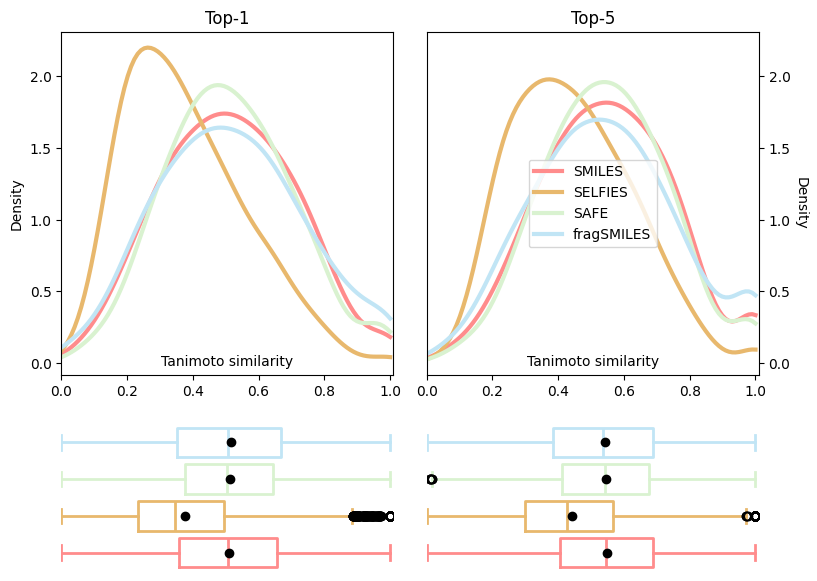

In [15]:
from scipy.stats import gaussian_kde

ks=(0,4)

fix, axes = plt.subplots(nrows=len(ks), ncols=2, figsize=(9,7), sharex=True, sharey='row',
                         gridspec_kw={'height_ratios': [.7, .3], 'wspace':0.1})
xs = np.linspace(0,1,100)
props = {'linewidth':2}

for position, row in notation_table.reset_index().iterrows():
    for k,(ax_kde, ax_box) in zip(ks, axes.T):
        
        props.update({'color':row.color})

        data = retrieve_def_sim_data(row.notation, k)

        density = gaussian_kde(data)
        density.covariance_factor = lambda : .25
        density._compute_covariance()

        ys = density(xs)
        ax_kde.plot(xs,ys,c=row.color, label=row['name'], lw=3)
        ax_kde.set_title(f'Top-{k+1}')
        ax_kde.set_ylabel('Density')
        ax_kde.set_xlabel('Tanimoto similarity')

        ax_kde.xaxis.set_label_coords(0.5,0.06)

        ax_box.axis("off")
        ax_box.boxplot(data, positions=[position], vert=False, widths=0.8, showmeans=True,
                       boxprops=props,flierprops=props, medianprops=props, capprops=props, whiskerprops=props,
                       meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black"})

        ax_box.invert_yaxis()
        
        ax_kde.set_xlim(0,1.01)

        ax_kde.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True,
        )    # labels along the bottom edge are on


        if k == 4:
            ax_kde.yaxis.tick_right()
            ax_kde.yaxis.set_tick_params(labelright=True)
            ax_kde.yaxis.set_label_position("right")
            ax_kde.set_ylabel('Density', rotation=-90, labelpad=12)

ax_kde.legend(loc='center')

In [16]:
fix.savefig('floats/figures/similarities.pdf', bbox_inches='tight')

# Statistical tests

In [17]:
from scipy import stats

In [18]:
from src.configs.constants import NOTATIONS
from itertools import combinations

In [19]:
for notation in NOTATIONS:
    for k in ks:
        # res_ks = stats.kstest(retrieve_def_sim_data(notation,k),'norm')
        res_ks = stats.shapiro(retrieve_def_sim_data(notation,k))
        
        print(res_ks)

ShapiroResult(statistic=0.9939298431563662, pvalue=2.1506648698269425e-29)
ShapiroResult(statistic=0.9927617001202145, pvalue=3.5799177068704336e-28)
ShapiroResult(statistic=0.9664574489360739, pvalue=3.430728454487929e-66)
ShapiroResult(statistic=0.9815973430881431, pvalue=4.551384065443254e-52)
ShapiroResult(statistic=0.9934508288818875, pvalue=2.0011418712182056e-34)
ShapiroResult(statistic=0.9951395890313552, pvalue=2.12562895821054e-28)
ShapiroResult(statistic=0.990313626365005, pvalue=2.0595586675363614e-35)
ShapiroResult(statistic=0.9870149762380911, pvalue=1.0745474558861686e-35)


/home/tox/Reactions/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22726.
  res = hypotest_fun_out(*samples, **kwds)
/home/tox/Reactions/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16963.
  res = hypotest_fun_out(*samples, **kwds)
/home/tox/Reactions/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 37723.
  res = hypotest_fun_out(*samples, **kwds)
/home/tox/Reactions/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32711.
  res = hypotest_fun_out(*samples, **kwds)
/home/tox/Reactions/.venv/lib/python

In [20]:
for k in ks:
	res_ks = stats.levene( *[retrieve_def_sim_data(notation,k) for notation in NOTATIONS])
	
	print(res_ks)

LeveneResult(statistic=413.54262156087714, pvalue=3.2420669327865276e-267)
LeveneResult(statistic=254.18766815820135, pvalue=2.697156653217921e-164)


In [21]:
for k in ks:
	res_ks = stats.f_oneway( *[retrieve_def_sim_data(notation,k) for notation in NOTATIONS])
	
	print(res_ks)

F_onewayResult(statistic=3957.2916242217293, pvalue=0.0)
F_onewayResult(statistic=1968.3286268448765, pvalue=0.0)


In [22]:
def cross_stats_test(dict_evaluators, k, test_fnc):
    adj = pd.DataFrame(index=NOTATIONS, columns=NOTATIONS)

    for not1,not2 in combinations(dict_evaluators.keys(), 2):
        data1=retrieve_def_sim_data(not1,k)
        data2=retrieve_def_sim_data(not2,k)

        pvalue = test_fnc(data1, data2).pvalue

        
        adj.at[not1,not2] = pvalue
        adj.at[not2,not1] = pvalue

    return adj

In [23]:
# TODO

from statsmodels.stats.multitest import multipletests

p_values = [stats.ttest_ind(a, b).pvalue for a, b in combinations([x1, x2, x3, x4], 2)]
adjusted_p = multipletests(p_values, method='bonferroni')[1]

print("Adjusted p-values:", adjusted_p)

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
from src.utils.extra import annotate_heatmap

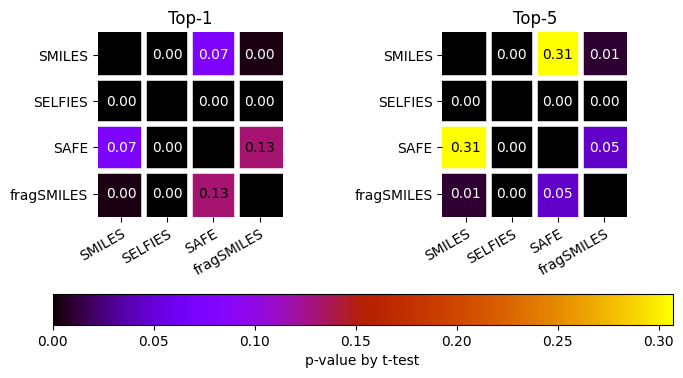

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4), gridspec_kw={'wspace':.25,})

ticks = np.arange(len(notation_table))
labels = notation_table.name.tolist()

test_fnc = partial(stats.ttest_ind, equal_var=True)

adj0 = cross_stats_test(evaluators_forward, 0, test_fnc).values
np.fill_diagonal(adj0, 0.0)
adj4 = cross_stats_test(evaluators_forward, 4, test_fnc).values
np.fill_diagonal(adj4, 0.0)

adjs = (adj0, adj4)

_max = max(adj0.flatten().max(), adj4.flatten().max())

for ax, k, adj in zip(axes.flatten(), ks, adjs) :
    
    im = ax.matshow(adj.astype(float), cmap = 'gnuplot', vmin=0.0, vmax=_max)

    ax.set_xticks(ticks, labels, rotation=30, ha="right", rotation_mode="anchor")
    ax.xaxis.set_ticks_position("bottom")
    ax.set_yticks(ticks, labels)

    ax.set_title(f'Top-{k+1}')

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(ticks[:-1]+.5, minor=True)
    ax.set_yticks(ticks[:-1]+.5, minor=True)

    ax.grid(which="minor", color="w", linestyle='-', linewidth=4)
    ax.tick_params(which="minor", bottom=False, left=False)

    annotate_heatmap(im, adj, textcolors=("white", "black"), threshold=.12)


cbar = fig.colorbar(im, ax=axes.flatten(), orientation='horizontal', pad = .25, location='bottom')
cbar.set_label('p-value by t-test', )


In [ ]:
fig.savefig('floats/figures/ttest.pdf')